In [1]:
import numpy as np #obliczenia numeryczne
import pandas as pd #struktura dataframe
import matplotlib.pyplot as plt #do rysowania wykresow, macierz korelacji
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer

In [2]:
train_df = pd.read_csv('dataset/train.csv', index_col='Id')

test_df = pd.read_csv('dataset/test.csv', index_col='Id')

In [3]:
train_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [4]:
#tworze kopie i zmienne dla X_prep i y_prep, aby skorzystac z Mutual information przed wyborem modelu i wlasciwym trenowaniem
#aby uniknac nadpisania danych, na ktroych docelowo bede pracowac

X_prep = train_df.copy()
y_prep = X_prep.pop('SalePrice')

In [5]:
#wyswietlam info ile jest brakujacych danych dla danej kolumny


print(test_df.isnull().sum().sort_values(ascending=False).head(40))

#wszystkich danych (domow) jest 1460
#PoolQC - Pool Quality (kat) - NA(1453) znaczy No Pool, wiec nie sa to brakujace dane
#MiscFeature - rozne cechy nie ujete w innych kategoriach (kat) - np. winda; NA oznacza brak takich cech, wiec cos nam to mowi
#Alley: Type of alley access to property; NA - brak dostepu do alei dojazdowej
#Fence - NA - brak ogrodzenia
#FireplaceQu - Fireplace quality; NA - no fireplace
#LotFrontage (LICZBOWE) - Stopy liniowe ulicy połączonej z nieruchomością; NA to brak ulicy? raczej brak danych -> most frequent
#GARAGE - wszystkie brakujace dane w year building dotycza braku garazu; 
#BsmtFinType2 - ocena powierzchni wykonczonej piwnicy; NA - brak piwnicy
#BsmtExposure - ekspozycja piwnicy (NA - brak piwnicy)
#BsmtCond i te 2 ponizej - NA - brak piwnicy; 
#MasVnrArea i Type- none - brak forniru murowanego + jego powierzchnia (liczbowy) - tutaj brakuje danych, bo na brak forniru jest
#none a nie n/a; dobrze wypelnic najczesciej wystepujacymi wartosciami
#Electrical - dana jakosciowa; najlepiej wypelnic najczesciej wystepujaca 

#jakosciowe kolumny, ktore trzeba uzupelnic o najczesciej wystepujace wartosci:
#1. MasVnrType 
#2. Electrical

#ilosciowe, ktore trzeba uzupelnic o najczesciej wystepujace wartosci:
#1. LotFrontage
#2. GarageYrBlt
#3. MasVnrArea

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
SaleType           1
BsmtFinSF1         1
GarageCars         1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
GarageArea         1
BsmtFinSF2         1
TotRmsAbvGrd       0
KitchenAbvGr       0
Fireplaces         0
MSSubClass         0
HalfBath           0
PavedDrive         0
WoodDeckSF         0
dtype: int64


In [6]:
test_df.GarageYrBlt

Id
1461    1961.0
1462    1958.0
1463    1997.0
1464    1998.0
1465    1992.0
         ...  
2915       NaN
2916    1970.0
2917    1960.0
2918       NaN
2919    1993.0
Name: GarageYrBlt, Length: 1459, dtype: float64

In [7]:
print(X_prep.shape) 

(1460, 79)


In [8]:
#korzystam z Mutual information zeby sprawdzic, ktore atrybuty najsilniej wplywaja na y


# koduje atykiety dla wartości kategorycznych
for colname in X_prep.select_dtypes("object"):
    X_prep[colname], _ = X_prep[colname].factorize()

# sprawdzam czy w X_prep sa same wartości całkowite (musza byc zeby skorzystac z MI)
discrete_features = X_prep.dtypes == int

In [9]:
discrete_features

MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
Street           False
                 ...  
MiscVal          False
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
Length: 79, dtype: bool

In [10]:
print(X_prep.isnull().sum().sort_values(ascending=False).head(20))

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
KitchenAbvGr      0
GarageType        0
FireplaceQu       0
Fireplaces        0
Functional        0
TotRmsAbvGrd      0
KitchenQual       0
MSSubClass        0
GarageFinish      0
HalfBath          0
FullBath          0
BsmtHalfBath      0
BsmtFullBath      0
GrLivArea         0
LowQualFinSF      0
2ndFlrSF          0
BedroomAbvGr      0
dtype: int64


In [11]:
# pozbywam sie brakujacych danych poprzez imputacje - wypelniam brakujace wartosci najczesciej wystepujaca w danej kolumnie
#powinno byc dla jakosciowych i ilosciowych na raz

# Imputation
my_imputer = SimpleImputer(strategy='most_frequent')
imputed_X_prep = pd.DataFrame(my_imputer.fit_transform(X_prep))

# Imputacja usuwa nazwy kolumn, dlatego je przywracam
imputed_X_prep.columns = X_prep.columns


In [12]:
all(discrete_features)

False

In [13]:
for colname in imputed_X_prep.select_dtypes('float64'):
    print(colname)

MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YrSold
SaleType
SaleCondition


In [14]:
X_prep = imputed_X_prep.astype(int)

In [15]:
X_prep.dtypes

MSSubClass       int32
MSZoning         int32
LotFrontage      int32
LotArea          int32
Street           int32
                 ...  
MiscVal          int32
MoSold           int32
YrSold           int32
SaleType         int32
SaleCondition    int32
Length: 79, dtype: object

In [16]:
def compute_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X_prep, y_prep, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = compute_mi_scores(X_prep, y_prep, discrete_features)
mi_scores.head()  

OverallQual    0.510900
GrLivArea      0.367155
GarageCars     0.354339
BsmtQual       0.329573
ExterQual      0.322420
dtype: float64

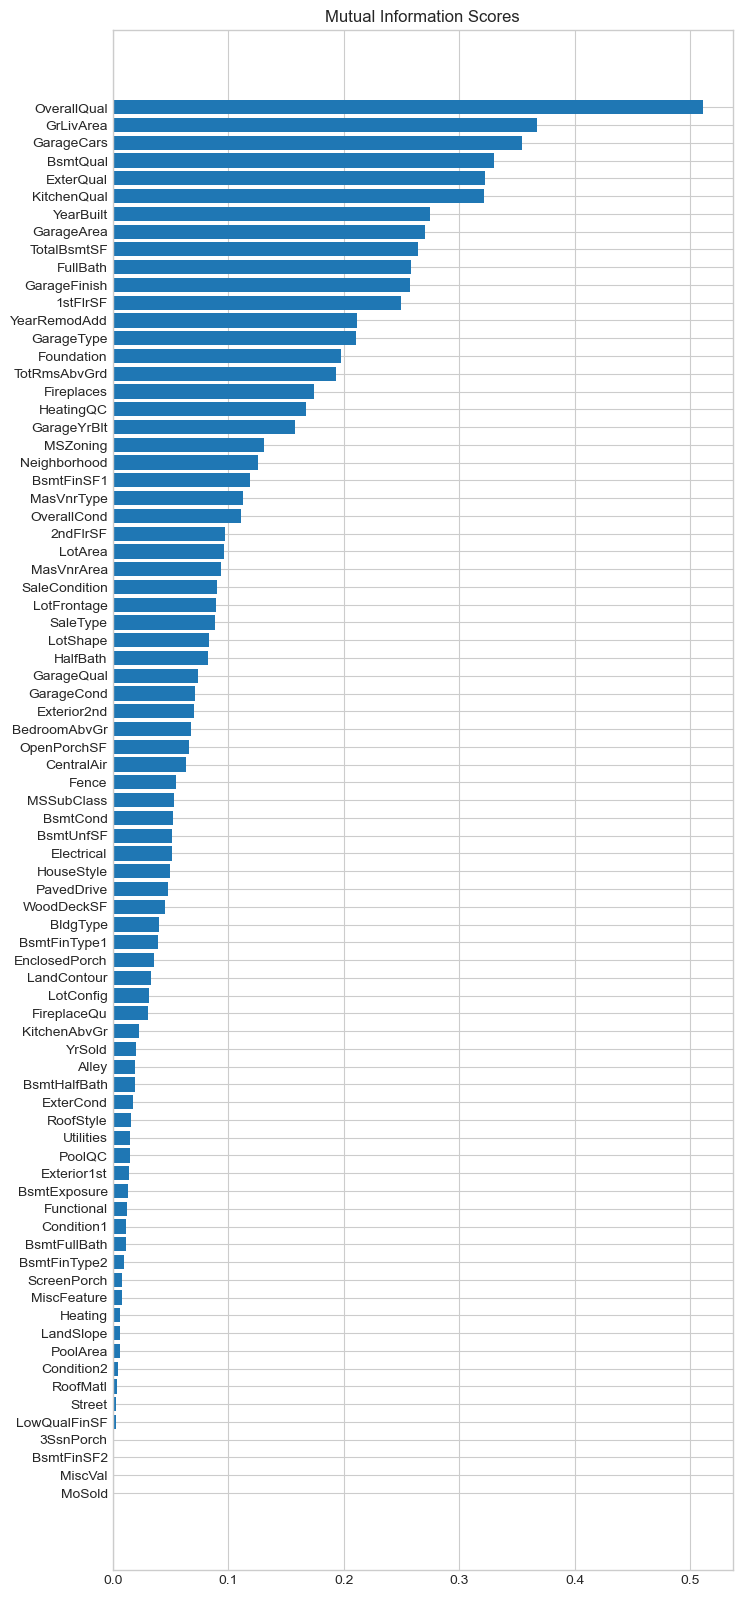

In [17]:
import seaborn as sns

plt.style.use("seaborn-whitegrid")

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 20))
plot_mi_scores(mi_scores)

In [18]:
X_prep.Functional

0       0
1       0
2       0
3       0
4       0
       ..
1455    0
1456    1
1457    0
1458    0
1459    0
Name: Functional, Length: 1460, dtype: int32

In [19]:
X_prep['SalePrice'] = y_prep

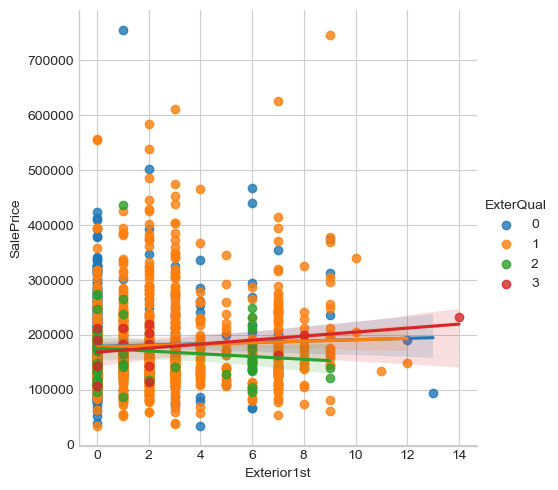

In [20]:
sns.lmplot(x="Exterior1st", y="SalePrice", hue='ExterQual', data=X_prep);

In [21]:
train_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [22]:
#usuwam kolumny z niskim MI (później będę sprawdzać, czy usunięcie danej kolumny dobrze wpływało na wynik modelu)
col_to_delete = ['PoolQC', 'MoSold', 'PoolArea', 'BsmtFinSF2', 'LowQualFinSF', 'Exterior1st', 'Utilities']

for col in col_to_delete:
    train_df.drop(col, axis = 1, inplace= True)
    test_df.drop(col, axis = 1, inplace= True)

In [23]:
#wyswietlam info ile jest brakujacych danych dla danej kolumny dla danych treningowych


print(train_df.isnull().sum().sort_values(ascending=False).head(20))

MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageQual        81
GarageCond        81
GarageFinish      81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
MasVnrArea         8
Electrical         1
KitchenAbvGr       0
KitchenQual        0
dtype: int64


In [24]:
#wyswietlam info ile jest brakujacych danych dla danej kolumny dla danych testowych


print(test_df.isnull().sum().sort_values(ascending=False).head(40))

MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730
LotFrontage       227
GarageFinish       78
GarageQual         78
GarageCond         78
GarageYrBlt        78
GarageType         76
BsmtCond           45
BsmtQual           44
BsmtExposure       44
BsmtFinType1       42
BsmtFinType2       42
MasVnrType         16
MasVnrArea         15
MSZoning            4
Functional          2
BsmtFullBath        2
BsmtHalfBath        2
Exterior2nd         1
GarageCars          1
GarageArea          1
SaleType            1
KitchenQual         1
BsmtFinSF1          1
BsmtUnfSF           1
TotalBsmtSF         1
MiscVal             0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
YrSold              0
ScreenPorch         0
FullBath            0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
dtype: int64


In [25]:
print(train_df.shape)

(1460, 73)


In [26]:
y = train_df.SalePrice
train_full = train_df.drop(['SalePrice'], axis = 1)

In [27]:
train_full['GarageBlt'] = train_full['GarageYrBlt'] > 0

In [28]:
train_full.loc[41, 'GarageBlt']

True

In [29]:
test_df['GarageBlt'] = test_df['GarageYrBlt'] > 0


In [30]:
test_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,GarageBlt
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,0,120,MnPrv,NaN,0,2010,WD,Normal,True
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,Corner,Gtl,...,0,0,0,NaN,Gar2,12500,2010,WD,Normal,True
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,0,0,MnPrv,NaN,0,2010,WD,Normal,True
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,0,0,NaN,NaN,0,2010,WD,Normal,True
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,Inside,Gtl,...,0,0,144,NaN,NaN,0,2010,WD,Normal,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,0,0,NaN,NaN,0,2006,WD,Normal,False
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,0,0,NaN,NaN,0,2006,WD,Abnorml,True
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,0,0,NaN,NaN,0,2006,WD,Abnorml,True


In [31]:
temp_X = pd.concat([train_df.MiscFeature, train_df.Alley], axis=1)


In [32]:
temp_X

,MiscFeature,Alley
Id,,
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
...,...,...
1456,NaN,NaN
1457,NaN,NaN
1458,Shed,NaN


In [33]:
# Imputation
cols_miss_val = ['MasVnrType', 'MSZoning', 'LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 
                 'Exterior2nd', 'KitchenQual', 'SaleType', 'GarageArea', 'GarageCars', 'BsmtUnfSF', 'BsmtFinSF1',
                'TotalBsmtSF']

my_imputer = SimpleImputer(strategy='most_frequent')
imputed_train_full = pd.DataFrame(my_imputer.fit_transform(train_full[cols_miss_val]))
imputed_test_df = pd.DataFrame(my_imputer.transform(test_df[cols_miss_val]))

# Imputation removed column names; put them back
imputed_train_full.columns = cols_miss_val
imputed_test_df.columns = cols_miss_val



In [34]:
imputed_train_full

,MasVnrType,MSZoning,LotFrontage,GarageYrBlt,MasVnrArea,BsmtFullBath,BsmtHalfBath,Exterior2nd,KitchenQual,SaleType,GarageArea,GarageCars,BsmtUnfSF,BsmtFinSF1,TotalBsmtSF
0,BrkFace,RL,65.0,2003.0,196.0,1,0,VinylSd,Gd,WD,548,2,150,706,856
1,None,RL,80.0,1976.0,0.0,0,1,MetalSd,TA,WD,460,2,284,978,1262
2,BrkFace,RL,68.0,2001.0,162.0,1,0,VinylSd,Gd,WD,608,2,434,486,920
3,None,RL,60.0,1998.0,0.0,1,0,Wd Shng,Gd,WD,642,3,540,216,756
4,BrkFace,RL,84.0,2000.0,350.0,1,0,VinylSd,Gd,WD,836,3,490,655,1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,None,RL,62.0,1999.0,0.0,0,0,VinylSd,TA,WD,460,2,953,0,953
1456,Stone,RL,85.0,1978.0,119.0,1,0,Plywood,TA,WD,500,2,589,790,1542
1457,None,RL,66.0,1941.0,0.0,0,0,CmentBd,Gd,WD,252,1,877,275,1152
1458,None,RL,68.0,1950.0,0.0,1,0,MetalSd,Gd,WD,240,1,0,49,1078


In [35]:
train_full = train_full.drop(cols_miss_val, axis=1)

In [36]:
test_df = test_df.drop(cols_miss_val, axis=1)

In [37]:
train_full.reset_index(drop=True, inplace=True)
imputed_train_full.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
imputed_test_df.reset_index(drop=True, inplace=True)
train_df_concat = pd.concat([train_full, imputed_train_full], axis=1)
test_df_concat = pd.concat([test_df, imputed_test_df], axis=1)
train_df_concat

,MSSubClass,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,BsmtFullBath,BsmtHalfBath,Exterior2nd,KitchenQual,SaleType,GarageArea,GarageCars,BsmtUnfSF,BsmtFinSF1,TotalBsmtSF
0,60,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,1,0,VinylSd,Gd,WD,548,2,150,706,856
1,20,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,1,MetalSd,TA,WD,460,2,284,978,1262
2,60,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,1,0,VinylSd,Gd,WD,608,2,434,486,920
3,70,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,1,0,Wd Shng,Gd,WD,642,3,540,216,756
4,60,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,1,0,VinylSd,Gd,WD,836,3,490,655,1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,Pave,NaN,Reg,Lvl,Inside,Gtl,Gilbert,Norm,...,0,0,VinylSd,TA,WD,460,2,953,0,953
1456,20,13175,Pave,NaN,Reg,Lvl,Inside,Gtl,NWAmes,Norm,...,1,0,Plywood,TA,WD,500,2,589,790,1542
1457,70,9042,Pave,NaN,Reg,Lvl,Inside,Gtl,Crawfor,Norm,...,0,0,CmentBd,Gd,WD,252,1,877,275,1152
1458,20,9717,Pave,NaN,Reg,Lvl,Inside,Gtl,NAmes,Norm,...,1,0,MetalSd,Gd,WD,240,1,0,49,1078


In [38]:
train_df_concat.LotFrontage = train_df_concat.LotFrontage.astype('float64')
train_df_concat.GarageYrBlt = train_df_concat.GarageYrBlt.astype('float64')
train_df_concat.MasVnrArea = train_df_concat.MasVnrArea.astype('float64')
train_df_concat.BsmtFullBath = train_df_concat.BsmtFullBath.astype('float64')
train_df_concat.BsmtHalfBath = train_df_concat.BsmtHalfBath.astype('float64')

test_df_concat.LotFrontage = test_df_concat.LotFrontage.astype('float64')
test_df_concat.GarageYrBlt = test_df_concat.GarageYrBlt.astype('float64')
test_df_concat.MasVnrArea = test_df_concat.MasVnrArea.astype('float64')
test_df_concat.BsmtFullBath = test_df_concat.BsmtFullBath.astype('float64')
test_df_concat.BsmtHalfBath = test_df_concat.BsmtHalfBath.astype('float64')

In [39]:
train_df_concat.dtypes == 'object'

MSSubClass     False
LotArea        False
Street          True
Alley           True
LotShape        True
               ...  
GarageArea      True
GarageCars      True
BsmtUnfSF       True
BsmtFinSF1      True
TotalBsmtSF     True
Length: 73, dtype: bool

In [40]:
imputed_train_full.dtypes

MasVnrType      object
MSZoning        object
LotFrontage     object
GarageYrBlt     object
MasVnrArea      object
BsmtFullBath    object
BsmtHalfBath    object
Exterior2nd     object
KitchenQual     object
SaleType        object
GarageArea      object
GarageCars      object
BsmtUnfSF       object
BsmtFinSF1      object
TotalBsmtSF     object
dtype: object

In [41]:
train_df_concat

,MSSubClass,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,BsmtFullBath,BsmtHalfBath,Exterior2nd,KitchenQual,SaleType,GarageArea,GarageCars,BsmtUnfSF,BsmtFinSF1,TotalBsmtSF
0,60,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,1.0,0.0,VinylSd,Gd,WD,548,2,150,706,856
1,20,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0.0,1.0,MetalSd,TA,WD,460,2,284,978,1262
2,60,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,1.0,0.0,VinylSd,Gd,WD,608,2,434,486,920
3,70,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,1.0,0.0,Wd Shng,Gd,WD,642,3,540,216,756
4,60,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,1.0,0.0,VinylSd,Gd,WD,836,3,490,655,1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,Pave,NaN,Reg,Lvl,Inside,Gtl,Gilbert,Norm,...,0.0,0.0,VinylSd,TA,WD,460,2,953,0,953
1456,20,13175,Pave,NaN,Reg,Lvl,Inside,Gtl,NWAmes,Norm,...,1.0,0.0,Plywood,TA,WD,500,2,589,790,1542
1457,70,9042,Pave,NaN,Reg,Lvl,Inside,Gtl,Crawfor,Norm,...,0.0,0.0,CmentBd,Gd,WD,252,1,877,275,1152
1458,20,9717,Pave,NaN,Reg,Lvl,Inside,Gtl,NAmes,Norm,...,1.0,0.0,MetalSd,Gd,WD,240,1,0,49,1078


In [42]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in train_df_concat.columns if train_df_concat[cname].nunique() < 10 and 
                        train_df_concat[cname].dtype == "object"]


In [43]:
categorical_cols

['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'MiscFeature',
 'SaleCondition',
 'MasVnrType',
 'MSZoning',
 'KitchenQual',
 'SaleType',
 'GarageCars']

In [44]:
numerical_cols = [cname for cname in train_df_concat.columns if train_df_concat[cname].dtype in ['int64', 'float64']]


In [45]:
numerical_cols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'YrSold',
 'LotFrontage',
 'GarageYrBlt',
 'MasVnrArea',
 'BsmtFullBath',
 'BsmtHalfBath']

In [46]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_df_concat[categorical_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_df_concat[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = train_df_concat.index
OH_cols_test.index = test_df_concat.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_df_concat[numerical_cols]#train_df_concat.drop(categorical_cols, axis=1)
num_X_test = test_df_concat[numerical_cols]#test_df_concat.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


In [47]:
OH_X_test

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,...,200,201,202,203,204,205,206,207,208,209
0,20,11622,5,6,1961,1961,896,0,896,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,20,14267,6,6,1958,1958,1329,0,1329,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,60,13830,5,5,1997,1998,928,701,1629,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,60,9978,6,6,1998,1998,926,678,1604,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,120,5005,8,5,1992,1992,1280,0,1280,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,1936,4,7,1970,1970,546,546,1092,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1455,160,1894,4,5,1970,1970,546,546,1092,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1456,20,20000,5,7,1960,1996,1224,0,1224,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1457,85,10441,5,5,1992,1992,970,0,970,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [48]:
OH_X_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,...,200,201,202,203,204,205,206,207,208,209
0,60,8450,7,5,2003,2003,856,854,1710,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,20,9600,6,8,1976,1976,1262,0,1262,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,60,11250,7,5,2001,2002,920,866,1786,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,70,9550,7,5,1915,1970,961,756,1717,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,60,14260,8,5,2000,2000,1145,1053,2198,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,953,694,1647,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1456,20,13175,6,6,1978,1988,2073,0,2073,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1457,70,9042,7,9,1941,2006,1188,1152,2340,2,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1458,20,9717,5,6,1950,1996,1078,0,1078,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(OH_X_train, y, train_size=0.8, test_size=0.2, random_state=1)

In [55]:
# plt.scatter(OH_X_train.GrLivArea,y)

In [56]:

# outliers=((OH_X_train['GrLivArea']>4000) & (y<300000))|((OH_X_train['OverallCond']==2) & (y>300000))
# OH_X_train.drop(OH_X_train[outliers].index,inplace=True)
# y.drop(y[outliers].index,inplace=True)
# plt.scatter(OH_X_train.OverallCond,y)

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor




In [58]:
model = XGBRegressor(n_estimators=2000, learning_rate = 0.01, n_jobs=2)


In [59]:
model.fit(X_train, y_train,
          verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=2, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [60]:
from sklearn.metrics import mean_absolute_error

predictions = model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 14824.815148758562


In [61]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(model, OH_X_train, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [15588.82903467 16987.4634477  18690.54275397 15152.48931486
 18603.59506551]


In [ ]:
#my_pipeline = Pipeline(steps=[('model', model)
                             #])

In [ ]:
#my_pipeline.fit XGBRegressor(n_estimators=n_estimators, 
                               #early_stopping_round=5,
                               #eval_set= [(X_valid, y_valid)],
                               #random_state=1))

In [ ]:
#def get_score(n_estimators):
    #"""Return the average MAE over 3 CV folds of random forest model.
    #Keyword argument:
    #n_estimators -- the number of trees in the forest
    #""" 
    #my_pipeline = Pipeline(steps=[
        #('model', XGBRegressor(n_estimators=n_estimators, 
                               #early_stopping_round=5,
                               #eval_set= [(X_valid, y_valid)],
                               #random_state=1))
    #])
        
    #score = -1 * cross_val_score(my_pipeline, OH_X_train, y,
                              #cv=5,
                              #scoring='neg_mean_absolute_error')
    #return score.mean()

In [ ]:
#results = {} 
#keys = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
#for key in keys:
    #results[key] = get_score(key)
    

In [ ]:
#import matplotlib.pyplot as plt
#%matplotlib inline

#plt.plot(list(results.keys()), list(results.values()))
#plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error

# Preprocessing of training data, fit model 
model.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = model.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 14824.815148758562


In [63]:
#przygotowujemy plik do submitu


In [64]:
final_X_test = OH_X_test 

In [65]:
sum(final_X_test.dtypes == 'object')

0

In [66]:
print(final_X_test.isnull().sum().sort_values(ascending=False).head(20))

MSSubClass    0
136           0
124           0
125           0
126           0
127           0
128           0
129           0
130           0
131           0
132           0
133           0
134           0
135           0
137           0
122           0
138           0
139           0
140           0
141           0
dtype: int64


In [67]:
final_X_test

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,...,200,201,202,203,204,205,206,207,208,209
0,20,11622,5,6,1961,1961,896,0,896,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,20,14267,6,6,1958,1958,1329,0,1329,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,60,13830,5,5,1997,1998,928,701,1629,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,60,9978,6,6,1998,1998,926,678,1604,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,120,5005,8,5,1992,1992,1280,0,1280,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,1936,4,7,1970,1970,546,546,1092,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1455,160,1894,4,5,1970,1970,546,546,1092,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1456,20,20000,5,7,1960,1996,1224,0,1224,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1457,85,10441,5,5,1992,1992,970,0,970,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [68]:
test_df = pd.read_csv('dataset/test.csv')


In [69]:
cols_for_testing = test_df.Id

In [70]:


# Fill in the line below: get test predictions
preds_test = model.predict(final_X_test)



# Save test predictions to file
output = pd.DataFrame({'Id': cols_for_testing,
                       'SalePrice': preds_test})
output.to_csv('dataset/XGBoost_results.csv', index=False)

In [71]:
final_X_test

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,...,200,201,202,203,204,205,206,207,208,209
0,20,11622,5,6,1961,1961,896,0,896,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,20,14267,6,6,1958,1958,1329,0,1329,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,60,13830,5,5,1997,1998,928,701,1629,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,60,9978,6,6,1998,1998,926,678,1604,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,120,5005,8,5,1992,1992,1280,0,1280,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,1936,4,7,1970,1970,546,546,1092,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1455,160,1894,4,5,1970,1970,546,546,1092,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1456,20,20000,5,7,1960,1996,1224,0,1224,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1457,85,10441,5,5,1992,1992,970,0,970,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [72]:
type(preds_test)

numpy.ndarray

In [73]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers


In [74]:
def HousePrices():
    model2 = models.Sequential()
    model2.add(layers.Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.001), input_shape=(237,)))
    model2.add(layers.Dropout(0.25))
    model2.add(layers.Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model2.add(layers.Dropout(0.25))
    model2.add(layers.Dense(32, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model2.add(layers.Dropout(0.25))
    model2.add(layers.Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model2.add(layers.Dropout(0.25))
    model2.add(layers.Dense(1, activation = 'linear'))
    model2.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
    return model2

In [75]:
model2 = HousePrices()

In [76]:
np.array(X_train).shape


(1168, 237)

In [77]:
np.array(y_train).reshape(1168,1).shape


(1168, 1)

In [78]:
history = model2.fit(np.array(X_train), np.array(y_train), epochs = 45, batch_size = 64, validation_split =0.2)

Epoch 1/45
15/15 [==============================] - 1s 34ms/step - loss: 39291498496.0000 - accuracy: 0.0000e+00 - val_loss: 34744614912.0000 - val_accuracy: 0.0000e+00
Epoch 2/45
15/15 [==============================] - 0s 6ms/step - loss: 36057796608.0000 - accuracy: 0.0000e+00 - val_loss: 29097728000.0000 - val_accuracy: 0.0000e+00
Epoch 3/45
15/15 [==============================] - 0s 5ms/step - loss: 27835017216.0000 - accuracy: 0.0000e+00 - val_loss: 17823784960.0000 - val_accuracy: 0.0000e+00
Epoch 4/45
15/15 [==============================] - 0s 6ms/step - loss: 16720136192.0000 - accuracy: 0.0000e+00 - val_loss: 17762729984.0000 - val_accuracy: 0.0000e+00
Epoch 5/45
15/15 [==============================] - 0s 5ms/step - loss: 10549815296.0000 - accuracy: 0.0000e+00 - val_loss: 17020230656.0000 - val_accuracy: 0.0000e+00
Epoch 6/45
15/15 [==============================] - 0s 6ms/step - loss: 9484482560.0000 - accuracy: 0.0000e+00 - val_loss: 13458616320.0000 - val_accuracy: 0.0

In [79]:
preds_valid = model2.predict(np.array(X_valid))

In [80]:
score = mean_absolute_error(y_valid, preds_valid)
print('MAE:', score)

MAE: 33493.37679259418


In [81]:
type(preds_valid)

numpy.ndarray

In [82]:
preds_test = model2.predict(np.array(final_X_test)) 

In [83]:
preds_test.reshape(1459).shape

(1459,)

In [84]:
# Save test predictions to file

output = pd.DataFrame({'Id': cols_for_testing,
                       'SalePrice': preds_test.reshape(1459)})
output.to_csv('dataset/sequential_model_results.csv', index=False)

In [85]:
X_valid.shape

(292, 237)